In [63]:
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import cv2 
import matplotlib.pyplot as plt
from functools import reduce

#Read styles.csv
styles = pd.read_csv('styles.csv', error_bad_lines=False, warn_bad_lines=False)
images = np.array(styles[['id']])
styles = styles[['id', 'subCategory']]
replaced_style = styles['subCategory'].replace({'Sandal': 'Shoes', 'Flip Flops': 'Shoes', 'Watches': 'Accessories', 'Jewellery' :'Accessories'})
replaced_df = pd.DataFrame(styles['id']).join(replaced_style)
print(replaced_df.shape)
fashion_df = replaced_df.loc[replaced_df['subCategory'] == 'Topwear'].append(replaced_df.loc[replaced_df['subCategory'] == 'Shoes']).append(replaced_df.loc[replaced_df['subCategory'] == 'Bottomwear']).append(replaced_df.loc[replaced_df['subCategory'] == 'Bags']).append(replaced_df.loc[replaced_df['subCategory'] == 'Accessories'])
print(fashion_df)
index = list(fashion_df.index)
print(len(index))

images_df = images[index]
links = ['/Users/mymac/Desktop/532/images/'+ str(images_df[i, 0]) + '.jpg' for i in range(34115)]


(44419, 2)
          id  subCategory
0      15970      Topwear
4      53759      Topwear
5       1855      Topwear
6      30805      Topwear
7      26960      Topwear
...      ...          ...
44385  45223  Accessories
44393  32371  Accessories
44398  45011  Accessories
44408  40563  Accessories
44418  51623  Accessories

[34115 rows x 2 columns]
34115


34115


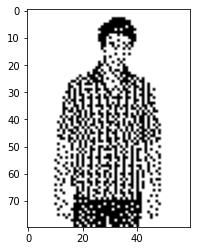

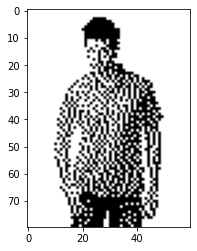

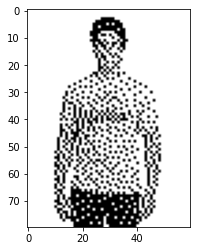

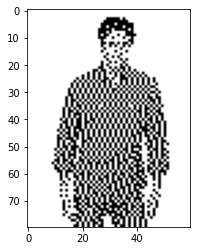

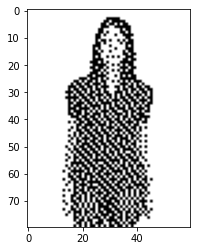

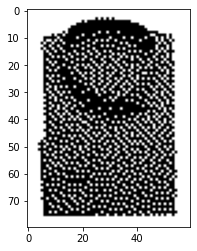

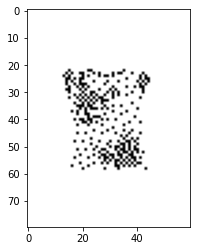

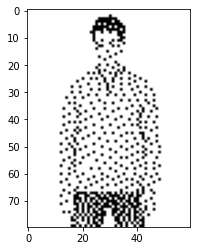

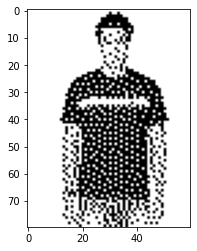

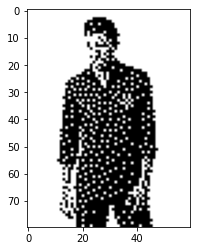

In [64]:
import skimage
from skimage import feature
import sys
filter_images = []
low_threshold = .1
high_threshold = .4
# len(im)
def filter(im):
    for i in range(len(im)):
        #image = np.array(im[i])
        #edges = skimage.feature.canny(image, sigma=.01)
        #edge_inv = np.array(np.logical_not(edges)*1)
        #filter_images.append(edge_inv)
        filter_images.append(np.float32(im[i])) 
# 34115
im = [Image.open(links[i]).convert('1') for i in range(34115)]

  

filter(im)
print(len(filter_images))

for i in range(10):
    plt.imshow(filter_images[i], cmap='gray')
    plt.show()



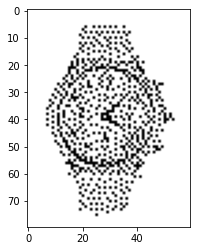

In [65]:
filter_images = np.array(filter_images)
y = fashion_df['subCategory'].replace({'Topwear': 1, 'Bottomwear': 2,  'Shoes': 3, 'Bags': 4,  'Accessories': 5})
plt.imshow(filter_images[32216], cmap='gray')
plt.show()
y = y.reset_index(level=None, drop=True) 
## The index has been reset to match the images



1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
3
3
3
3
3
3
3
2
2
2
4
4


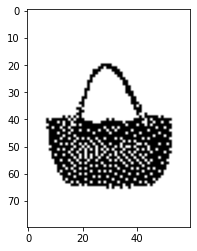

In [66]:

#A  =  pd.DataFrame({'col':filter_images})
#A = np.array([filter_images[1],  filter_images[2], filter_images[3], filter_images[4]])
#print(A.shape)
A = []
df = pd.DataFrame()
df = pd.DataFrame(styles['id']).join(replaced_style)
d = []
for i in range(len(filter_images)):
    A.append(filter_images[i])
    d.append(y[i])
for i in range(30):
    plt.imshow(A[i*1000], cmap='gray')
    print(y[i*1000])

In [68]:

#Remove all images that dont have shape (80,60)
for i in range(len(A)):
    if(A[i].shape != (80,60)):
        del A[i]
        i+1
        del d[i]

A = np.array(A)
#A = np.dstack(A)


In [71]:
col = np.sum(A[0], axis = 1)
print(col.shape)
row = np.sum(A[0], axis = 0)
print(row.shape)
A_old = []
C = A.copy()
C_old = []
for i in range(0, len(A)):
    col = np.sum(A[i], axis = 1)
    row = np.sum(A[i], axis = 0)
    A_new = np.concatenate((col, row), axis=0)
    A_old.append(A_new)
B = np.array(A_old)

for i in range(0, len(A)):
    feature = C[i].flatten('F')
    C_old.append(feature)
B2 = np.array(C_old)



(80,)
(60,)
[1. 1. 1. ... 1. 1. 1.]


In [72]:
# normal len(d)
K=len(d)
m = [[],[],[],[],[],[],[],[]]  
m[0] = np.array([k for k in range(0,K,5)]).T    
m[1] = np.array([k for k in range(1,K,5)]).T    
m[2] = np.array([k for k in range(2,K,5)]).T
m[3] = np.array([k for k in range(3,K,5)]).T 
m[4] = np.array([k for k in range(4,K,5)]).T  
r = []    
r.append(reduce(np.union1d, (m[1],m[2],m[3],m[4])))  
r.append(reduce(np.union1d, (m[0],m[2],m[3],m[4])))     
r.append(reduce(np.union1d, (m[0],m[1],m[3],m[4])))  
r.append(reduce(np.union1d, (m[0],m[1],m[2],m[4])))  
r.append(reduce(np.union1d, (m[0],m[1],m[2],m[3])))  

In [73]:
## Linear regression model 
# one hot encodeing
d = np.array(d)
b = []
for i in range(len(d)):
    if(d[i] == 1):
        b.append([0,0,0,0,1])
    if(d[i] == 2):
        b.append([0,0,0,1,0])
    if(d[i] == 3):
        b.append([0,0,1,0,0])
    if(d[i] == 4):
        b.append([0,1,0,0,0])
    if(d[i] == 5):
        b.append([1,0,0,0,0])
y = np.array(b)
## Ridge regression least squares 
w = np.linalg.inv(B.T@B + .1*np.identity(140))@B.T@y
print(w.shape)

(140, 5)


In [74]:
def linear(A, y, f):
    λ_vals = np.array([.1, .2, 1, 2, 4, 8, 16])
    total_error = 0
    for j in range(len(λ_vals)):
        average_error = 0
        for i in range(0,5):
            X_train, X_test, y_train, y_test = A[r[i]], A[m[i]], y[r[i]], y[m[i]]
            w_hat = np.array(np.linalg.inv(X_train.T@X_train + np.identity(f)*λ_vals[j])@X_train.T@y_train)
            error = 0
            for i in range(len(y_test)):
                y_hat = X_test[i]@w_hat
                y_tilda = list(y_hat).index(max(y_hat))
                d = list(y_test[i]).index(1)
                if(d != y_tilda):
                    error +=1
            average_error +=error
        print('error for λ= ' +str(λ_vals[j]) + '  ' +  str(average_error / (len(y_test))))

In [75]:
linear(B,y,140)

error for λ= 0.1  0.42712609970674487
error for λ= 0.2  0.42712609970674487
error for λ= 1.0  0.42712609970674487
error for λ= 2.0  0.42712609970674487
error for λ= 4.0  0.42712609970674487
error for λ= 8.0  0.42712609970674487
error for λ= 16.0  0.42712609970674487


In [77]:
linear(B2,y,4800)

error for λ= 0.1  0.25747800586510267
error for λ= 0.2  0.2538123167155425
error for λ= 1.0  0.24193548387096775
error for λ= 2.0  0.23343108504398827
error for λ= 4.0  0.22668621700879765
error for λ= 8.0  0.21788856304985338
error for λ= 16.0  0.21158357771260997


In [85]:
## KNN algorithm 

def find_k_max(norm, k):
    min_values = []
    norm_temp = norm.copy()
    indices = []
    for i in range(k):
        min_value = min(norm_temp)
        min_values.append(min_value)
        del norm_temp[norm_temp.index(min_value)]
    for j in range(k):
        indices.append(norm.index(min_values[j]))
    return indices
        
    
    

In [ ]:
import statistics 
from statistics import mode    
count = 0 
for i in range(0,1):
    X_train, X_test, y_train, y_test = A[r[i]], A[m[i]], d[r[i]], d[m[i]]
    for j in range(len(X_test)):    
        new = (X_train + X_test[j])%2
        norm = np.linalg.norm(new, axis=(1,2))
        index = find_k_max(list(norm), 3)
        if(j%100 == 0):
            print(y_train[index])
            print(y_test[j])
        if(mode(y_train[index]) != y_test[j]):
            count += 1 
    print(count/len(y_test))
            

[1 1 1]
1
[5 1 1]
1
[1 1 1]
1
[1 1 1]
1
[1 1 1]
1
[1 1 1]
1
[1 1 1]
1
[1 1 1]
1
[1 1 1]
1
[1 1 1]
1
[5 2 2]
1
[1 1 1]
1
[1 1 1]
1
[5 5 5]
1
[1 2 5]
1
[1 1 1]
1
[1 1 1]
1
[1 1 1]
1
[1 1 1]
1
[1 1 1]
1
[2 4 3]
1
[1 1 1]
1
[1 5 5]
1
[1 1 1]
1
[5 5 5]
1
[1 1 1]
1
[1 1 1]
1
[1 5 5]
1
[1 1 1]
1
[5 5 5]
1
[1 1 1]
1
[3 3 3]
3
[5 5 5]
3
[3 3 3]
3
[5 5 5]
3
[3 3 3]
3
[3 3 3]
3


In [79]:
def find_k_max_mawr(norm, k):
    norm_index = {_norm: index for index, _norm in enumerate(norm)}
    max_values = sorted(norm)[:k]
    return [norm_index[_norm] for _norm in max_values]

In [ ]:
w = [1, 4 ,5, 8, 10, 2]
print(find_k_max_mawr(w,3))

In [ ]:
import statistics 
from statistics import mode    
count = 0 
for i in range(0,1):
    X_train, X_test, y_train, y_test = A[r[i]], A[m[i]], d[r[i]], d[m[i]]
    for j in range(len(X_test)):
        norm = [np.linalg.norm(X_test[j]-X_train[k]) for k in range(len(X_train))]
        index = find_k_max_mawr(norm, 3)
        if(mode(y_train[index]) != y_test[j]):
            count += 1 
    print(count/len(y_test))

In [ ]:

new = X_test[0] + X_train
norm2 = np.linalg.norm(new, axis=0)
print(new.shape)
print(new[10,:,30])
print(test[:,30])
print(X_train[10,:,30])
print(new[10,:,30] %2)
print(norm2.shape)

In [ ]:
norm = np.linalg.norm(new, axis=(1,2))
print(norm.shape)

In [ ]:
new = (X_test[0] + X_train) %2
norm = np.linalg.norm(new, axis=(1,2))